**In part 2, we will perform multi-class classification on the nfr dataset.  Specially, we will focus on classifying non-functional requirements into one of the 6 types.**

In [331]:
'''data'''
import pandas as pd
import numpy as np
import spacy
import re
import pickle
import pprint
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2


%run helpers.ipynb

'''Visualization'''
import matplotlib.pyplot as plt
import seaborn as sns

''' Features'''
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

'''Estimators'''
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier

'''Modelling'''
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score 
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc, confusion_matrix, classification_report

##  Import processed data

In [232]:
nfr = pd.read_csv("../processed_data/nfr_processed.csv")

In [233]:
nfr = nfr.loc[nfr["labels"]!="F",:] # keep only non-functional requirements
nfr= nfr.reset_index(drop=True)
nfr.shape

(370, 7)

In [234]:
class_count = nfr.groupby("labels").trigrams.count() # number of requirements in each class
class_count=class_count.reset_index()

In [235]:
class_count.sort_values(by="trigrams", ascending=False, inplace=True)

Text(0, 0.5, 'count')

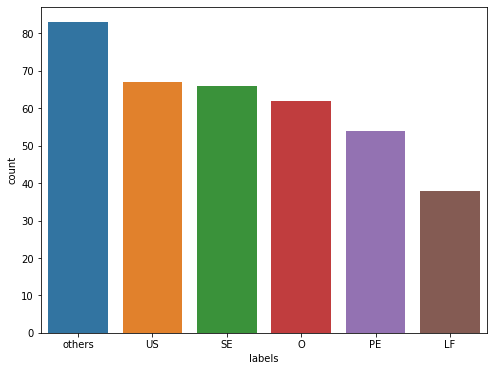

In [236]:
fig = plt.figure(figsize=(8,6))
sns.barplot(x="labels",y="trigrams", data=class_count)
plt.ylabel('count')

**Due to the imbalances classes, classifiers might bias towards to majority class.  In some cases, we might need to artifically up-sample classes like LF with sampling with replacement to create more balanace classes.**

## Vector representation of requirement texts
- As before, we want to represent the requirements with a vector of tfidf weights.
- This time, we will also set some of the parameters of TfidfVectorizer:
    - sublinear_tf: is set to True to use a logarithmic form for frequency.
    - min_df: the minimum numbers of documents a word must be present in to be kept
    - norm: set to l2 so that all feature vectors have a euclidian norm of 1
    - ngram_range is set to (1, 3) to indicate that we want to consider unigrams, bigrams, and trigrams.

In [305]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=1, norm="l2", ngram_range =(1,2))

In [306]:
features = tfidf.fit_transform(nfr.trigrams).toarray()
features.shape

(370, 3513)

In [307]:
labels_num = nfr.labels_num
label_dict = {"LF":1, "O":2, "PE":3, "SE":4, "US":5, "others":6} # mapping of labels and label_num

## Chi-sq test to find the most relevant term (feature) for each class
- Useful reference: http://ethen8181.github.io/machine-learning/text_classification/chisquare.html

- One common feature selection method that is used with text data is the Chi-Square feature selection. 
- The  χ2  test is used in statistics to test the independence of two RVs. 
- In our case, we compute the chi-square score for each feature (term) and its corresponding class and use it to test whether the occurrence of a specific term and the occurrence of a specific class are independent. 
- For each term t (feature) in a corpus with 370 documents (my sample), we estimate its chi-sq score with a specific class c.
- For each feature (term), a high χ2 score indicates that the null hypothesis H0 (independence between the term and class) is rejected. 
- Thus, a high chi-sq score means that there IS dependence between term's frequency and class c.  I should include this term (feature) in my classifier.

In [308]:
# Compute χ² (chi-squared) statistic for each class/feature combination.
features_chi2 = chi2(features, labels_num == 1) 
features_chi2

(array([0.06288193, 0.03013643, 0.02047817, ..., 0.03119536, 0.0361907 ,
        0.0361907 ]),
 array([0.80199758, 0.86218103, 0.88620966, ..., 0.85980525, 0.84912222,
        0.84912222]))

- The chi2 function returns "features_chi2", which is a tuple of two ndarray of shape 6357. 
- The first tuple contains the chi-sq scores for the 6357 terms (features): the higher the score, the higher the correlation between the feature and class 1.
- The second tuple contains the p-score of the chi-sq test for the 6357 terms: the smaller the p-value the better since we can reject the Ho and accept H1 (that there is dependence between the feature and class 1)

In [312]:
num_most_important = 5
for labels, cat_id in sorted(label_dict.items()):
     # I use labels_num == cat_id to create a boolean series where True means label_num of a row is equal to cat_id
    features_chi2 = chi2(features, labels_num == cat_id)
    
    # The indices of each of the 6357 features, sorted by least important (lowest chi-sq score) to the most important
    # (highest chi-sq score)
    # NOTE: np.argsort() return an array of index with the index of the element with the smallest value appearing first
    # np.argsort([3,1,2]) ---> array([1, 2, 0])
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices] # least important term to the most important term
    
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    unigram_str = '\n'.join(unigrams[-num_most_important:])
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    bigram_str = '\n'.join(bigrams[-num_most_important:])
  
    
    print("############### '{} ###############':".format(labels))
    print("## Most correlated unigrams ##")
    print(unigram_str)
    print("")
    print("## Most correlated bigrams ##")
    print(bigram_str)
    print("")
    

############### 'LF ###############':
## Most correlated unigrams ##
sound
look
simulate
appearance
ship

## Most correlated bigrams ##
professional appearance
simulate sound
user interface
comply corporate
shall simulate

############### 'O ###############':
## Most correlated unigrams ##
database_management
web
server
browser
environment

## Most correlated bigrams ##
central server
database_management system
shall run
able interface
shall interface

############### 'PE ###############':
## Most correlated unigrams ##
return
longer_second
let
response_time
second

## Most correlated bigrams ##
acceptable time
second time
website minute
shall return
shall let

############### 'SE ###############':
## Most correlated unigrams ##
prevent
logon
information
access
authorize

## Most correlated bigrams ##
authorize personnel
shall ensure
shall prevent
shall access
authorize user

############### 'US ###############':
## Most correlated unigrams ##
able_successfully
use
intuitive
training
e

## Modelling
- As before, I will first split the data into train and test datasets
- I will try 3 estimators: SVC, RandomForestClassifier, and AdaboostClassifier
- I will create a pipeline with the following steps:
    - tfidfvectorizer: represent each requirements with the tfidf weights of its tokens
    - TruncatedSVD: pick the most important features
    - clf: train classifier
 - For each estimator, I will use GridSearchCV to find its optimal hyperparameters based on its estimated test f1-score (marcro).


In [177]:
# Test harness
X = nfr["trigrams"]
y = nfr['labels_num'].values 

# Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 10)

In [179]:
# Classifiers
models = {
    'SVC': SVC(random_state=10),
    'RandomForestClassifier': RandomForestClassifier(random_state=10),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=10)
}

#Parameters for GridSearchCV
params = {
    
    'SVC':  { 
        "clf__C" : [ 1, 10, 100, 1000], # [1,10,100,1000]
        "clf__gamma" : [1,0.1,0.001,0.0001], # [1,0.1,0.001,0.0001]
    },
    
    'RandomForestClassifier':  { 
        "clf__n_estimators" : [200, 400, 800, 1000, 1200], # [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800] 
        "clf__max_depth"      : [10,30,50,80,100],  # [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
        "clf__min_samples_split" : [2,5,10],  # [2, 5, 10]
        "clf__min_samples_leaf" :   [1,2,4]   # [1, 2, 4]  
    },
    
    'AdaBoostClassifier':  { 
        "clf__n_estimators" : [100, 500, 800, 1000], # [100, 500, 800, 1000]
        "clf__learning_rate" : [0.01,0.05,0.1,0.5,1] # [0.01,0.05,0.1,0.5,1]
    }
}

In [191]:
 gscvs = []
    
for name in models.keys():
    # Pipeline
    pipeline = Pipeline([('tfidf', tfidf),  # compute for each term t in doc d its tf-idf weight
                         ('lsa', TruncatedSVD(n_components=100, n_iter=10, random_state=10)), # pick only 100 features
                         ('clf', models[name])])  # classifier
    
    est_params = params[name] # parameters for that model
    
    # Define the GridSearchCV object for that model
    gscv = GridSearchCV(estimator=pipeline, 
                            param_grid=est_params, 
                            cv=5,
                            verbose = 2,
                            n_jobs=-1, 
                            scoring = "f1_macro") 
        
    # Train the GridSearchCV object
    gscv.fit(X_train, y_train)
    
    print("The best parameters are: {}".format(gscv.best_params_))
    print("")
    print("The best f1-macro score (on CV) are: {}".format(gscv.best_score_))
    
    gscvs.append(gscv)
    

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   18.2s finished


The best parameters are: {'clf__C': 100, 'clf__gamma': 1}

The best f1-macro score (on CV) are: 0.7248480924445109
Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed: 20.0min finished


The best parameters are: {'clf__max_depth': 30, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 1200}

The best f1-macro score (on CV) are: 0.6537736623560053
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished


The best parameters are: {'clf__learning_rate': 0.5, 'clf__n_estimators': 1000}

The best f1-macro score (on CV) are: 0.3355453722621172


In [196]:
# Get the metrics of each model

model_name, acc_score_list, precision_score_list, recall_score_list, f1_score_list = [], [], [], [], []
for i,name in enumerate(models.keys()):
    # Get predictions
    y_pred = gscvs[i].predict(X_test)
    
    # model name
    model_name.append(name)
    
    # Model performance
    acc_score_list.append(accuracy_score(y_test, y_pred))
    # compute precision of each class and take average
    precision_score_list.append(precision_score(y_test, y_pred, average='macro')) 
    recall_score_list.append(recall_score(y_test, y_pred, average='macro'))
    f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
    
    # Organize metrics (on test dataset) for each model in a DataFrame
    model_comparison_df = pd.DataFrame(list(zip(model_name, acc_score_list, precision_score_list,
                                                recall_score_list, f1_score_list)), 
                                                columns= ['model_name', 'accuracy_score', 
                                                          'precision_score','recall_score', 'f1_score'])
    
    # sort by f1_score
    model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)


In [197]:
model_comparison_df

,model_name,accuracy_score,precision_score,recall_score,f1_score
0,SVC,0.738739,0.763939,0.722028,0.734496
1,RandomForestClassifier,0.666667,0.788675,0.620939,0.635793
2,AdaBoostClassifier,0.423423,0.740839,0.383441,0.361828


**Again, SVC outperforms more complex models such as AdaBoostClassifier.  Given the class imbalance and the very small sample size, the performance for RandomForest and SVC is surprisingly good.**      

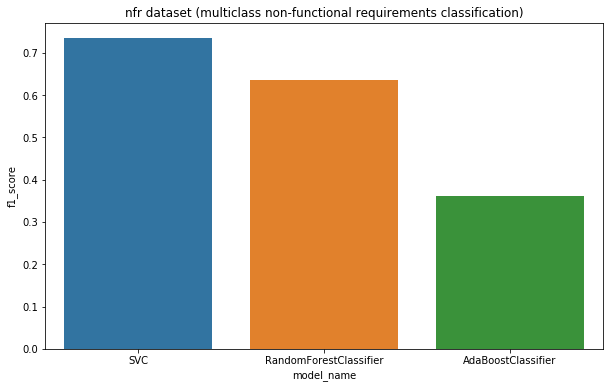

In [344]:
## Plots
fig,ax = plt.subplots(figsize=(10,6))
sns.barplot(x="model_name", y="f1_score", data=model_comparison_df, axes=ax)

ax.set_title('nfr dataset (multiclass non-functional requirements classification)')

plt.savefig("../outputs/multi_class_classification_results.jpeg")

## Model evaluation
- Let's look at the confusion matrix, classification report for SVC (our best model)

In [313]:
model = gscvs[0]

In [315]:
y_pred = model.predict(X_test)

In [316]:
conf_mat = confusion_matrix(y_test, y_pred)

**The diagonal elements are correctly predicted by the model.  I see small off-diagonal values.**

In [327]:
conf_mat

array([[ 6,  2,  0,  0,  1,  2],
       [ 0, 13,  0,  1,  0,  5],
       [ 0,  1, 13,  1,  0,  1],
       [ 0,  1,  2, 14,  2,  1],
       [ 1,  1,  1,  0, 15,  2],
       [ 0,  1,  0,  1,  2, 21]], dtype=int64)

**Plot heatmap for confusion matrix**

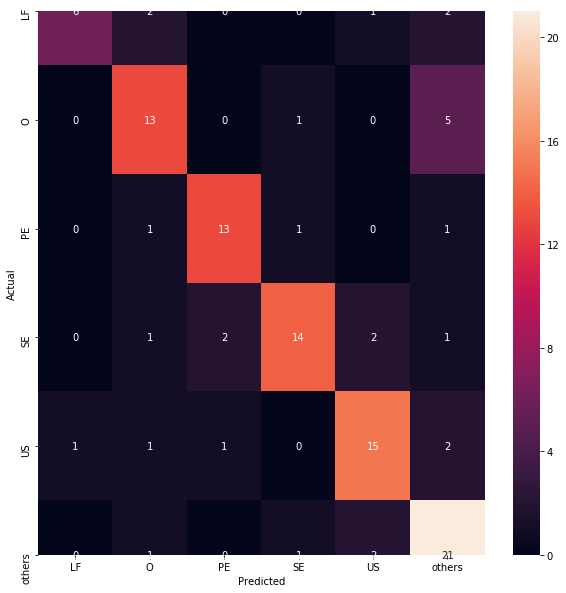

In [347]:
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=list(label_dict.keys()),  yticklabels=list(label_dict.keys()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig("../outputs/multi_class_classification_svc_cm.jpeg")
plt.show()

**The SVC model mostly incorrectly predicts "O" to "others, but the vast majority of the predictions are correct.**

**Classification reports for each class**

In [332]:
print(classification_report(y_test, y_pred, target_names=list(label_dict.keys())))

              precision    recall  f1-score   support

          LF       0.86      0.55      0.67        11
           O       0.68      0.68      0.68        19
          PE       0.81      0.81      0.81        16
          SE       0.82      0.70      0.76        20
          US       0.75      0.75      0.75        20
      others       0.66      0.84      0.74        25

    accuracy                           0.74       111
   macro avg       0.76      0.72      0.73       111
weighted avg       0.75      0.74      0.74       111



**Thoughts**

Not surprisingly, the SVC model has a high precision but low recall for LF. This because LF accounts for the least amounts of requirements in the sample.  The model returns very few results, but most if its predictions are correct.
On the other hand, the model has low precision and high recall for "others".  The class "others" basically lumps classes that appears very infrequently in the dataset.  The model makes a lot of predictions but a lot of them are not correct.

## Outputs

In [346]:
model_comparison_df.to_csv("../outputs/multiclass_results.csv", index=False)